In [95]:
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
import seaborn as sns
sns.set(style="whitegrid")

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [97]:
device

device(type='cuda')

Sources Referenced, Credit to: https://huggingface.co/datasets/iwslt2017 , https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html, https://nlp.seas.harvard.edu/2018/04/03/attention.html

### Using Hugging Face To Load Data

In [371]:
#French, Dutch , Korean, Arabic, German, Italian, Romanian
languages = ['French', 'Dutch', 'Korean', 'Arabic', 'German', 'Italian', 'Romanian']

In [372]:
from datasets import load_dataset
tasks = ['iwslt2017-en-fr', 'iwslt2017-en-nl', 'iwslt2017-en-ko', 'iwslt2017-en-ar', 'iwslt2017-en-de', 'iwslt2017-en-it', 'iwslt2017-en-ro']
datasets = []
#load_dataset('iwslt2017')
for task in tasks:
    dataset = load_dataset('iwslt2017',task)
    dataset.set_format(type='numpy')
    datasets.append(dataset)

Found cached dataset iwslt2017 (C:/Users/StevenKoniaev/.cache/huggingface/datasets/iwslt2017/iwslt2017-en-fr/1.0.0/03ce9110373117c6f6687719f49f269486a8cd49dcad2527993a316cd4b6ad49)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset iwslt2017 (C:/Users/StevenKoniaev/.cache/huggingface/datasets/iwslt2017/iwslt2017-en-nl/1.0.0/03ce9110373117c6f6687719f49f269486a8cd49dcad2527993a316cd4b6ad49)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset iwslt2017 (C:/Users/StevenKoniaev/.cache/huggingface/datasets/iwslt2017/iwslt2017-en-ko/1.0.0/03ce9110373117c6f6687719f49f269486a8cd49dcad2527993a316cd4b6ad49)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset iwslt2017 (C:/Users/StevenKoniaev/.cache/huggingface/datasets/iwslt2017/iwslt2017-en-ar/1.0.0/03ce9110373117c6f6687719f49f269486a8cd49dcad2527993a316cd4b6ad49)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset iwslt2017 (C:/Users/StevenKoniaev/.cache/huggingface/datasets/iwslt2017/iwslt2017-en-de/1.0.0/03ce9110373117c6f6687719f49f269486a8cd49dcad2527993a316cd4b6ad49)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset iwslt2017 (C:/Users/StevenKoniaev/.cache/huggingface/datasets/iwslt2017/iwslt2017-en-it/1.0.0/03ce9110373117c6f6687719f49f269486a8cd49dcad2527993a316cd4b6ad49)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset iwslt2017 (C:/Users/StevenKoniaev/.cache/huggingface/datasets/iwslt2017/iwslt2017-en-ro/1.0.0/03ce9110373117c6f6687719f49f269486a8cd49dcad2527993a316cd4b6ad49)


  0%|          | 0/3 [00:00<?, ?it/s]

In [373]:
#Convert into the format we want
for i, dataset in enumerate(datasets):
    datasets[i] = {'train' : pd.DataFrame(np.array(dataset['train']['translation']).tolist()),
                   'test' : pd.DataFrame(np.array(dataset['test']['translation']).tolist())}

In [374]:
#Make sure second column is english
for i in range(len(datasets)):
    new_column_order =  [col for col in datasets[i]['train'].columns if col != 'en'] + ['en']
    datasets[i]['train'] = datasets[i]['train'][new_column_order]
    datasets[i]['test'] = datasets[i]['test'][new_column_order]

In [375]:
#Example
datasets[0]['test']

,fr,en
0,"Il y a plusieurs années, ici à Ted, Peter Skil...","Several years ago here at TED, Peter Skillman ..."
1,Et l'idée est plutôt simple. Des équipes de qu...,And the idea's pretty simple: Teams of four h...
2,Le marshmallow doit être placé au sommet.,The marshmallow has to be on top.
3,"Bien que cela semble vraiment simple, c'est en...","And, though it seems really simple, it's actua..."
4,"J'ai trouvé que c'était une idée intéressante,...","And so, I thought this was an interesting idea..."
...,...,...
8592,Et la réponse c'est que la capacité à poursuiv...,"And the answer is, the ability to seek goals ..."
8593,d'une tendance sur le long terme à augmenter l...,from a long-term drive to increase future fre...
8594,"Enfin, Richard Feynman, physicien célèbre, écr...","Finally, Richard Feynman, famous physicist, o..."
8595,Mon équivalent pour ce message à laisser à nos...,My equivalent of that statement to pass on to...


In [376]:
SOS_token = 0
EOS_token = 1
#Standard class for tokenizing and generating a vocabulary
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def inLang(self, word):
        if word not in self.word2index:
            return False
        else:
            return True

In [377]:
def cleanString(s):
    s = re.sub('\W+',' ', s)
    ' '.join([i for i in s])
    return s.lower().strip()

In [378]:
#Clean strings as defined above
for i in range(len(datasets)):
    datasets[i]['train'] = datasets[i]['train'].apply(np.vectorize(cleanString)).to_numpy()
    datasets[i]['test'] =  datasets[i]['test'].apply(np.vectorize(cleanString)).to_numpy()

In [379]:
#Example
datasets[6]['train']

array([['mulțumesc foarte mult chris și trebuie să spun că mă simt onorat să am ocazia de a veni pe scenă de două ori sunt foarte recunoscător',
        'thank you so much chris and it s truly a great honor to have the opportunity to come to this stage twice i m extremely grateful'],
       ['am fost bulversat de conferința aceasta și vreau să vă mulțumesc tuturor pentru multele comentarii frumoase la ce am avut de spus seara trecută',
        'i have been blown away by this conference and i want to thank all of you for the many nice comments about what i had to say the other night'],
       ['și o spun cu sinceritate mai mult pentru că am nevoie de asta puneți vă în locul meu',
        'and i say that sincerely partly because i need that put yourselves in my position'],
       ...,
       ['eu și soția mea avem doi copii iar una din speranțele mele ca bioinginer e să le facem viața mai bună decât este acum pentru noi',
        'you know my wife and i have two young kids and one of my 

In [380]:
MAX_LENGTH = 20

def filterLength(s):
    return len(s[0].split(' ')) < MAX_LENGTH and len(s[1].split(' ')) < MAX_LENGTH

def filterSentences(sentences):
    return np.array([s for s in sentences if filterLength(s)])

In [381]:
#Reduce size of senteces to our max length
for i in range(len(datasets)):
    datasets[i]['train'] = filterSentences(datasets[i]['train'])
    datasets[i]['test'] = filterSentences(datasets[i]['test'])

In [382]:
#Create a language class for each language
lang_classes = [Lang(lang) for lang in languages]
lang_classes.append(Lang('eng'))

In [383]:
###Look at frequency counts of words for each dataset, remove words that dont meet threshold
for j in range(len(datasets)):
    vocab = {}
    for i, sentence in enumerate(datasets[j]['train']):
        for word in sentence[0].split(' '):
            if word not in vocab:
                vocab[word] = {'index' : [i], 'count' : 1}
            else:
                vocab[word]['index'].append(i)
                vocab[word]['count'] += 1

    indicies = []
    for v in vocab:
        if vocab[v]['count'] <= 2:
            indicies += vocab[v]['index']
    datasets[j]['train'] = np.delete(datasets[j]['train'], indicies, axis=0)

In [384]:
###Look at frequency counts of ENGLISH words for each dataset, remove words that dont meet threshold
for j in range(len(datasets)):
    vocab = {}
    for i, sentence in enumerate(datasets[j]['train']):
        for word in sentence[1].split(' '):
            if word not in vocab:
                vocab[word] = {'index' : [i], 'count' : 1}
            else:
                vocab[word]['index'].append(i)
                vocab[word]['count'] += 1

    indicies = []
    for v in vocab:
        if vocab[v]['count'] <= 5:
            indicies += vocab[v]['index']
    datasets[j]['train'] = np.delete(datasets[j]['train'], indicies, axis=0)

In [385]:
###Create vocab for each language, reusing the english lang
for i in range(len(datasets)):
    for j in datasets[i]['train']:
        lang_classes[-1].addSentence(j[1]) #-1 will always point to eng language
        lang_classes[i].addSentence(j[0]) #Add to corresponding language

In [386]:
print(f"Vocabulary Sizes for each language")
for lang in lang_classes:
    print(f"{lang.name} has {lang.n_words} words")

Vocabulary Sizes for each language
French has 15732 words
Dutch has 17392 words
Korean has 25756 words
Arabic has 29021 words
German has 16571 words
Italian has 18628 words
Romanian has 22024 words
eng has 9989 words


In [387]:
#Do the same for test set
for j in range(len(datasets)):
    indicies = []
    for i, sentence in enumerate(datasets[j]['test']):
        for word in sentence[0].split(' '):
            if not lang_classes[j].inLang(word):
                indicies.append(i)
    datasets[j]['test'] = np.delete(datasets[j]['test'], indicies, axis=0)

In [388]:
#Do the same for test set
for j in range(len(datasets)):
    indicies = []
    for i, sentence in enumerate(datasets[j]['test']):
        for word in sentence[1].split(' '):
            if not lang_classes[-1].inLang(word):
                indicies.append(i)
    datasets[j]['test'] = np.delete(datasets[j]['test'], indicies, axis=0)

In [389]:
for i in range(len(datasets)):
    print(f"{languages[i]} Train: {len(datasets[i]['train'])} Test: {len(datasets[i]['test'])}")

French Train: 88014 Test: 3094
Dutch Train: 99567 Test: 753
Korean Train: 34887 Test: 992
Arabic Train: 64170 Test: 2112
German Train: 69029 Test: 2692
Italian Train: 90316 Test: 627
Romanian Train: 80083 Test: 668


In [390]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size,  hidden_size, embed_dim=256, dropout_p=0.15, bi_dir = False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embed_dim)
        self.bi_dir = bi_dir
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True, num_layers=1, bidirectional=self.bi_dir)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(2*hidden_size, hidden_size)
    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        if self.bi_dir:
            hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))).unsqueeze(0)
        return output, hidden

In [391]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, bi_dir=False):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        if bi_dir:
            self.Ua = nn.Linear(hidden_size * 2, hidden_size) # * 2 on input for biderctional
        else:
            self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, embed_dim=256, bi_dir=False):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size,embed_dim)
        self.attention = BahdanauAttention(hidden_size, bi_dir=bi_dir)
        self.bi_dir = bi_dir
        if bi_dir:
            self.gru = nn.GRU(embed_dim + hidden_size + hidden_size, hidden_size, batch_first=True, num_layers=1) #+ hidden size
        else:
            self.gru = nn.GRU(embed_dim + hidden_size, hidden_size, batch_first=True, num_layers=1) #+ hidden size
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(2*hidden_size, hidden_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [392]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def get_dataloader(batch_size, input_lang):
    pairs = datasets[input_lang]['train']
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(lang_classes[input_lang], inp)
        tgt_ids = indexesFromSentence(lang_classes[-1], tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids), torch.LongTensor(target_ids))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=2)
    return train_dataloader

In [393]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion):

    total_loss = 0
    for i, data in enumerate(dataloader):
        input_tensor, target_tensor = data
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()
        #if i % 1500 == 0:
        #    print(f"Iter: {i} Loss: {loss.item()}")
    return total_loss / len(dataloader)

In [394]:
import matplotlib.pyplot as plt
import os
def pltLosses(loss, saveImg=False, title="Loss vs Epoch", lang=""):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} of {lang} to English")
    if saveImg:
        filename = f"{lang}_to_eng.png"
        # Check if the file already exists
        counter = 1
        while os.path.exists(filename):
            filename = f"{counter}_{title}.png"
            counter += 1
        plt.savefig(f"./graphs/{filename}", bbox_inches='tight')
    plt.show()

In [395]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001):
    plot_losses = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(n_epochs):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print (f"Epoch: [{epoch+1} / {n_epochs}] Loss: {loss}")
        plot_losses.append(loss)

    return plot_losses

In [396]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [397]:
def evaluateRandomly(encoder, decoder, input_lang, n=10, set='test'):
    for i in range(n):
        pair = random.choice(datasets[input_lang][set])
        print('From:', pair[0])
        print('To:', pair[1])
        #input pair, input language, output language
        output_words, _ = evaluate(encoder, decoder, pair[0], lang_classes[input_lang], lang_classes[-1])
        output_sentence = ' '.join(output_words[:len(output_words)-1])
        print('Prediction:', output_sentence)
        print('')

In [398]:
def evaluateFirstN(encoder, decoder, input_lang, n=20):
    for i in range(n):
        pair = (datasets[input_lang]['test'][i])
        print('From:', pair[0])
        print('To:', pair[1])
        #input pair, input language, output language
        output_words, _ = evaluate(encoder, decoder, pair[0], lang_classes[input_lang], lang_classes[-1])
        output_sentence = ' '.join(output_words[:len(output_words)-1])
        print('Prediction:', output_sentence)
        print('')

In [399]:
def compute_metrics(encoder, decoder, input_lang):
    scores = []
    for i, pair in enumerate(datasets[input_lang]['test']):
        output_words, _ = evaluate(encoder, decoder, pair[0], lang_classes[input_lang], lang_classes[-1])
        output_sentence = ' '.join(output_words[:len(output_words)-1])
        #print(pair[1])
        #print(output_sentence)
        smoot_func = SmoothingFunction().method1
        bleu = sentence_bleu(references=[pair[1]], hypothesis=output_sentence, smoothing_function=smoot_func)
       # bleu = sentence_bleu(references=[pair[1]], hypothesis=output_sentence, weights=(0.5, 0.5), smoothing_function=smoot_func)
        scores.append(bleu)
    return np.mean(scores) * 100

In [400]:
languages

['French', 'Dutch', 'Korean', 'Arabic', 'German', 'Italian', 'Romanian']

In [317]:
input_lang = languages.index('French')

In [318]:
hidden_size = 768 #1024 #768 #256 #128
batch_size = 32
train_dataloader = get_dataloader(batch_size, input_lang)

In [319]:
len(train_dataloader)

2751

In [321]:
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size, bi_dir=True).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words, bi_dir=True).to(device)

In [322]:
model_parameters = filter(lambda p: p.requires_grad, decoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

19093766

In [323]:
print("STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.1271283649522927
Epoch: [2 / 20] Loss: 1.4497700266645674
Epoch: [3 / 20] Loss: 1.1646940363662452
Epoch: [4 / 20] Loss: 0.9795238953943645
Epoch: [5 / 20] Loss: 0.8387493150574821
Epoch: [6 / 20] Loss: 0.7250986587173589
Epoch: [7 / 20] Loss: 0.6291563149388597
Epoch: [8 / 20] Loss: 0.5473871534735625
Epoch: [9 / 20] Loss: 0.4791943341201108
Epoch: [10 / 20] Loss: 0.4201394705144504
Epoch: [11 / 20] Loss: 0.371142369829408
Epoch: [12 / 20] Loss: 0.32903772121839026
Epoch: [13 / 20] Loss: 0.2954187727990648
Epoch: [14 / 20] Loss: 0.26697563964186993
Epoch: [15 / 20] Loss: 0.24218538163283312
Epoch: [16 / 20] Loss: 0.22260651676785248
Epoch: [17 / 20] Loss: 0.205820391477996
Epoch: [18 / 20] Loss: 0.1935423833539121
Epoch: [19 / 20] Loss: 0.18271548410126703
Epoch: [20 / 20] Loss: 0.17337107912697214


In [324]:
losses = train(train_dataloader, encoder, decoder, 5, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.12100121881020628
Epoch: [2 / 5] Loss: 0.09232747410696578
Epoch: [3 / 5] Loss: 0.07982068358551844
Epoch: [4 / 5] Loss: 0.07186734536747333
Epoch: [5 / 5] Loss: 0.06630343527498245


In [325]:
compute_metrics(encoder, decoder, input_lang)

51.49060761338451

In [327]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: le gouvernement a donc décidé d organiser de nouvelles élections
To: so the government decided to have the elections once again
Prediction: so the government has decided to have any new elections

From: et aujourd hui vous verriez ceci a l intérieur de la mine 800 mètres sous terre
To: and today you would see this inside the mine half a mile underground
Prediction: and today would you like this now the inside half a mile underground

From: ensuite nous faisons une transformation mathématique pour la conception de la peau synthétique que vous voyez à droite
To: we then do a mathematical transformation to the design of the synthetic skin shown on the right
Prediction: we then do a mathematical transformation to the design of the synthetic skin shown on the right

From: j ai fait cette publicité je ne crois pas en ce genre d alcool mais j en bois parfois
To: i did this ad i don t believe in this kind of alcohol but i do drink sometimes
Prediction: i did this ad i don t believe in th

In [328]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: donc on pourrait facilement fournir au monde des dizaines voire des centaines de villes nouvelles
To: so we could easily supply the world with dozens maybe hundreds of new cities
Prediction: so we could easily lead to the world of tens and the hundreds of cities cities

From: je me laisse parfois emporter je vais finir avec cette histoire
To: i sometimes get out of balance i ll end with this story
Prediction: i ll explain my time i m going to finish with this story

From: ce sont des choix que vos petits enfants ou leurs petits enfants auront à faire
To: these are choices that your grandchildren or their grandchildren are going to have before them
Prediction: these are choices that your children are young children their children are trying to do

From: une structure quasiment identique
To: an almost identical structure
Prediction: it s flying been structure

From: et au fil du temps ça change ça change parce que les gens font les choses tout naturellement
To: and over time it cha

In [329]:
evaluateFirstN(encoder, decoder, input_lang)

From: et ça a été un grand succès
To: and it was a huge success
Prediction: and it was a huge success

From: ils passent la majeure partie de leur temps à assembler les bâtons en structures de plus en plus grandes
To: they spend the majority of their time assembling the sticks into ever growing structures
Prediction: they have a long time they have to sell them in and get to large their feet

From: et c est vraiment étonnant
To: and it s pretty amazing
Prediction: and it s really amazing

From: alors la question qu on se pose c est comment ça se fait pourquoi qu ont ils de spécial
To: so the question you want to ask is how come why what is it about them
Prediction: so the question we ask is how is that why they were special

From: mais il y a aussi une autre raison
To: but there s another reason as well
Prediction: but there s also another reason

From: c est que les étudiants des écoles de commerce sont entrainés à trouver l unique plan qui marchera
To: and the reason is that business

French

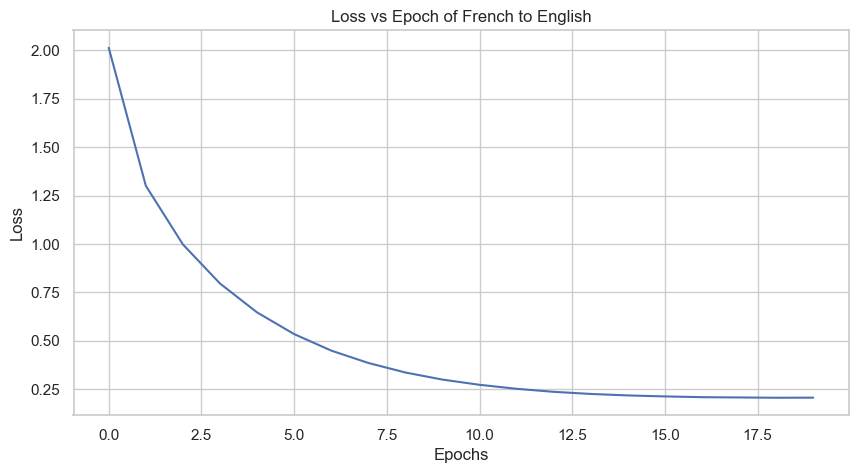

In [191]:
pltLosses(losses, saveImg=True, lang = languages[input_lang])

In [193]:
compute_metrics(encoder, decoder, input_lang)

44.52114762299725

In [194]:
evaluateRandomly(encoder, decoder, input_lang)

From: ils utilisent simplement leurs corps au meilleur de leurs capacités
To: they are just using their bodies to the best of their capacity
Prediction: they re just doing their bodies to the best of their life their movements

From: je voudrais vous inviter à fermer les yeux
To: i d like to invite you to close your eyes
Prediction: i m thinking about close your eyes

From: nous sommes très fiers de vous
To: we re proud of you
Prediction: we are proud of you

From: mais un comprimé blanc n est pas aussi bon qu une comprimé bleu
To: but a white pill is not as good as a blue pill
Prediction: but a white guy is not as good as a blue construct

From: les lignes blanches sont la population
To: so the white lines here are population
Prediction: the white lines are the population

From: pas vraiment l idéal pour la propagande d accord
To: that s just not convenient for propaganda got it
Prediction: not actually the ideal for propaganda whatsoever right

From: je ne lui ai pas coupé les ailes 

In [195]:
evaluateFirstN(encoder, decoder, input_lang)

From: et ça a été un grand succès
To: and it was a huge success
Prediction: and that has been a big success story it got

From: ils passent la majeure partie de leur temps à assembler les bâtons en structures de plus en plus grandes
To: they spend the majority of their time assembling the sticks into ever growing structures
Prediction: they understand the music part of their time series in the bigger and more characters

From: et c est vraiment étonnant
To: and it s pretty amazing
Prediction: and that s really pretty amazing and it s really pretty fascinating and it s really tiny

From: alors la question qu on se pose c est comment ça se fait pourquoi qu ont ils de spécial
To: so the question you want to ask is how come why what is it about them
Prediction: so then the question is how is this how why do they have to get caught

From: mais il y a aussi une autre raison
To: but there s another reason as well
Prediction: but there s also another reason as well

From: c est que les étudian

Dutch

In [289]:
input_lang = languages.index('Dutch')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.2088255616417274
Epoch: [2 / 20] Loss: 1.5063262319426916
Epoch: [3 / 20] Loss: 1.209223481675653
Epoch: [4 / 20] Loss: 1.0152134610708698
Epoch: [5 / 20] Loss: 0.867192725729973
Epoch: [6 / 20] Loss: 0.7466315029136319
Epoch: [7 / 20] Loss: 0.6490319070997612
Epoch: [8 / 20] Loss: 0.5684449661207076
Epoch: [9 / 20] Loss: 0.5016686656730187
Epoch: [10 / 20] Loss: 0.4453415648681339
Epoch: [11 / 20] Loss: 0.399338914076666
Epoch: [12 / 20] Loss: 0.36054340003963303
Epoch: [13 / 20] Loss: 0.3286321506067
Epoch: [14 / 20] Loss: 0.301940897407829
Epoch: [15 / 20] Loss: 0.279713780865801
Epoch: [16 / 20] Loss: 0.2610737944792736
Epoch: [17 / 20] Loss: 0.24642470868299585
Epoch: [18 / 20] Loss: 0.23314789261735958
Epoch: [19 / 20] Loss: 0.22371855696093454
Epoch: [20 / 20] Loss: 0.21438479306209823


In [290]:
losses += train(train_dataloader, encoder, decoder, 5, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.15014374382066084
Epoch: [2 / 5] Loss: 0.11586948891665912
Epoch: [3 / 5] Loss: 0.10097554727316209
Epoch: [4 / 5] Loss: 0.0910496880135147
Epoch: [5 / 5] Loss: 0.0831962407286492


In [291]:
compute_metrics(encoder, decoder, input_lang)

46.23802124200635

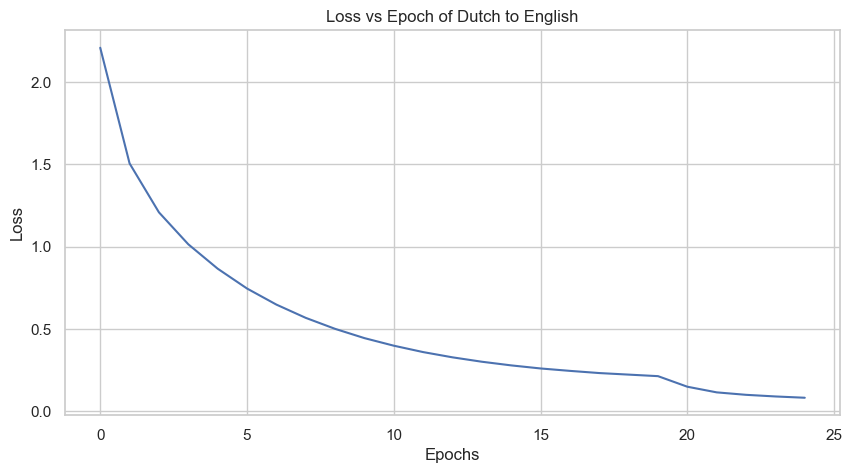

In [292]:
pltLosses(losses, saveImg=True, lang = languages[input_lang])

In [293]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: ze is niet schaalbaar werkt niet wereldwijd al zeker niet in de virtuele wereld
To: it doesn t scale it doesn t work globally and it surely doesn t work virtually
Prediction: she doesn t scale is not working there s not globally a million market

From: je moet je aanpassen
To: so you have to adapt
Prediction: so you shouldn t adapt

From: een voorbeeld
To: so here s an example
Prediction: an example

From: 30 seconden ga het netwerk in maak de knoop
To: thirty seconds into the network make the node
Prediction: thirty seconds the stress will get the network in the breast make the node

From: we hebben tevens keuzes nodig voor mensen
To: we also need the choices for people
Prediction: we also have the choices that we humans for people

From: we zitten allemaal in hetzelfde schuitje
To: and we re all in this together
Prediction: now we are all in this together

From: je verbergt het omdat het stigma rond depressie in onze samenleving zeer reëel is
To: you hide it because the stigma 

In [294]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: en dat gebeurde ook na drie maanden
To: and that s what happened at the end of that three month period
Prediction: after three months after three months

From: ik ga verder en kies overheid
To: i m going to go ahead and select government
Prediction: and i m going to get on and go shopping

From: mooi trucje iemand die geen jeugd gehad heeft zit in de zaal
To: pointing out like this nice one someone who didn t have a childhood is out there
Prediction: beautiful somebody who s not asked you re not really in any room

From: en de belangrijkste les die we hebben geleerd denk ik is dat ze echt van elkaar verschillen
To: and the main lesson i think that we have learned is they are really different
Prediction: and the biggest lesson that we ve learned is that they really are really looking for

From: zelfs geen idee het is een proces
To: it s not even an idea it s a process
Prediction: not even an idea it s a process it s an process

From: het internet en zijn diensten zijn een wonder
T

In [295]:
evaluateFirstN(encoder, decoder, input_lang)

From: de marshmallow moet er bovenop
To: the marshmallow has to be on top
Prediction: allowed to have to go on and on it

From: en het was een groot succes
To: and it was a huge success
Prediction: successful

From: dan gaan ze plannen organiseren
To: then they spend some time planning organizing
Prediction: going to organize the money going to organize

From: ze schetsen en monteren spaghetti
To: they sketch and they lay out spaghetti
Prediction: and begin and begin issue

From: het grootste deel van de tijd bouwen ze steeds grotere bouwwerken van de spaghetti
To: they spend the majority of their time assembling the sticks into ever growing structures
Prediction: the most beautiful thing they re getting closer building out of the electronic ones

From: ze bewonderen hun werk
To: they admire their work
Prediction: because they do their work

From: bepaalde mensen hebben meer van die oh oh momenten dan anderen
To: so there are a number of people who have a lot more uh oh moments than ot

Test with bidirectional Encoder

In [161]:
input_lang = languages.index('Dutch')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.210485733298532
Epoch: [2 / 20] Loss: 1.536941002144605
Epoch: [3 / 20] Loss: 1.2622768827031694
Epoch: [4 / 20] Loss: 1.0834756515211494
Epoch: [5 / 20] Loss: 0.9460019584754745
Epoch: [6 / 20] Loss: 0.8329865965695338
Epoch: [7 / 20] Loss: 0.7374594651430769
Epoch: [8 / 20] Loss: 0.6558990205870343
Epoch: [9 / 20] Loss: 0.5864851520921087
Epoch: [10 / 20] Loss: 0.5254749247665423
Epoch: [11 / 20] Loss: 0.47456273132968685
Epoch: [12 / 20] Loss: 0.43096713418653354
Epoch: [13 / 20] Loss: 0.3935519752253067
Epoch: [14 / 20] Loss: 0.3609420533045399
Epoch: [15 / 20] Loss: 0.33452107767385353
Epoch: [16 / 20] Loss: 0.3117023768109344
Epoch: [17 / 20] Loss: 0.2924093111803645
Epoch: [18 / 20] Loss: 0.2755193254912804
Epoch: [19 / 20] Loss: 0.2616235886300629
Epoch: [20 / 20] Loss: 0.24984259951313847


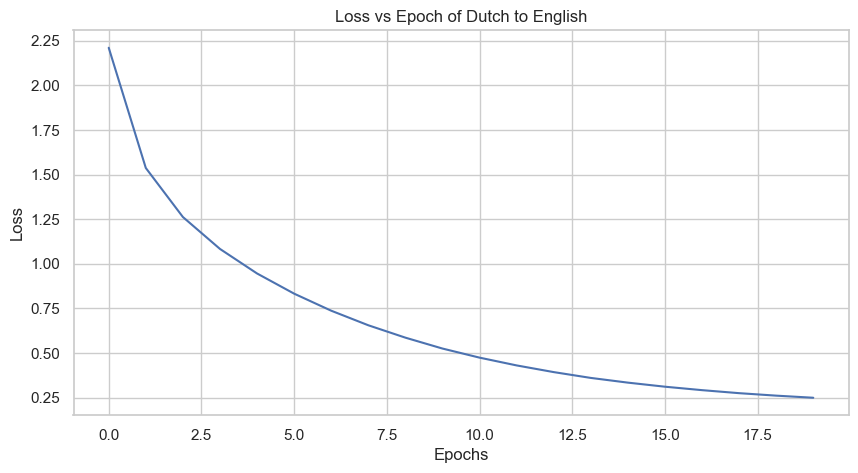

In [162]:
pltLosses(losses, saveImg=True, lang = languages[input_lang])

In [163]:
compute_metrics(encoder, decoder, input_lang)

47.286659347716586

In [164]:
evaluateRandomly(encoder, decoder, input_lang)

From: er is veel dat samen moet komen
To: there s a lot that has to come together
Prediction: and there s been much better coming out

From: ca als dit niet werkt wat dan
To: ca if this doesn t work then what
Prediction: ca so if this isn t what that then is

From: niet alleen voor de prachtige band
To: to understand not only the beautiful bond
Prediction: so it s not just wonderful wonderful

From: en wat we dus op globale schaal moeten doen is een nieuw systeem creëren
To: and so what we re going to have to do at a global scale is create a new system
Prediction: and so what we need to do is we need to do a new idea of creating this

From: je kan ermee achteruit in de tijd of vooruit in de tijd maar niet hier en nu blijven
To: and you can go backwards you can go forwards you cannot stay where you are
Prediction: you can quit in green or what do you do today and spend over here today

From: en zo hebben we een prachtige situatie met elektriciteit in de rijke wereld
To: and so we re in 

In [58]:
evaluateFirstN(encoder, decoder, input_lang)

From: de marshmallow challenge
To: called the marshmallow challenge
Prediction: the whole question in the position

From: de marshmallow moet er bovenop
To: the marshmallow has to be on top
Prediction: it has to go a cave and then revisit those

From: en omdat ik dit een interessant idee vond besloot ik het op te nemen in een design workshop
To: and so i thought this was an interesting idea and i incorporated it into a design workshop
Prediction: and i decided to find this a really interesting idea i decided to take a in a design workshop

From: en het was een groot succes
To: and it was a huge success
Prediction: success it was a big success

From: dan gaan ze plannen organiseren
To: then they spend some time planning organizing
Prediction: then they slowly plan they prepared

From: ze schetsen en monteren spaghetti
To: they sketch and they lay out spaghetti
Prediction: they re nuts and respect you spirit to replace new

From: het grootste deel van de tijd bouwen ze steeds grotere bou

Korean

In [279]:
input_lang = languages.index('Korean')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.1574563031672995
Epoch: [2 / 20] Loss: 1.7572471412576522
Epoch: [3 / 20] Loss: 1.5404743587719423
Epoch: [4 / 20] Loss: 1.3359884600044936
Epoch: [5 / 20] Loss: 1.1312357208031674
Epoch: [6 / 20] Loss: 0.9351841490493795
Epoch: [7 / 20] Loss: 0.7554172707412573
Epoch: [8 / 20] Loss: 0.5989924706416213
Epoch: [9 / 20] Loss: 0.46856403716871436
Epoch: [10 / 20] Loss: 0.3646084771284152
Epoch: [11 / 20] Loss: 0.2833434660755965
Epoch: [12 / 20] Loss: 0.22190184316211178
Epoch: [13 / 20] Loss: 0.1760340578218975
Epoch: [14 / 20] Loss: 0.14429145866337442
Epoch: [15 / 20] Loss: 0.12020836099231057
Epoch: [16 / 20] Loss: 0.10396695255850784
Epoch: [17 / 20] Loss: 0.0917329253931039
Epoch: [18 / 20] Loss: 0.08332461172306789
Epoch: [19 / 20] Loss: 0.07714698706453924
Epoch: [20 / 20] Loss: 0.07040611261503615


In [280]:
losses += train(train_dataloader, encoder, decoder, 5, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.04773121985831357
Epoch: [2 / 5] Loss: 0.03248265583587146
Epoch: [3 / 5] Loss: 0.027219398736810323
Epoch: [4 / 5] Loss: 0.024434349440741604
Epoch: [5 / 5] Loss: 0.023234179724045404


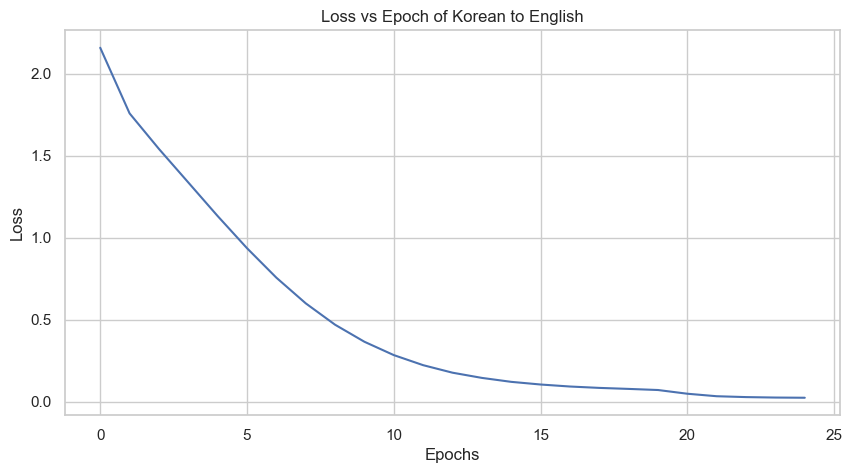

In [281]:
pltLosses(losses, saveImg=True, lang = languages[input_lang])


In [282]:
compute_metrics(encoder, decoder, input_lang)

23.363046671778672

In [286]:
evaluateFirstN(encoder, decoder, input_lang)

From: 또 다른 이유가 있습니다
To: but there s another reason as well
Prediction: there another reason for this

From: 그런데 제가 재미있는 일을 해봤습니다
To: and i tried something interesting
Prediction: it was fun to work

From: 어떻게 되었을 까요
To: so what do you think happened to these design students
Prediction: what happens to the time

From: 결과가 궁금하시죠
To: what was the result
Prediction: we have the results

From: 우리는 똑같은 실험은 같은 학생들에게 해보았습니다
To: we did the exercise again with the same students
Prediction: same sort of same like this same same

From: 어떤일이 일어났을까요
To: what do you think happened then
Prediction: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

From: 자세한 설명이 있어요
To: there s step by step instructions on this
Prediction: living organisms a little bit

From: 감사합니다
To: thank you very much
Prediction: thank you

From: 여기에 어떤 기계가 있다고 가정해봅시다
To: let s pretend right here we have a machine
Prediction: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

Fro

In [287]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: 그러면 어떻게 될까요
To: so how does it work
Prediction: so how does it

From: 제가 계산을 좀 해봤죠
To: so i did some calculations
Prediction: so i did some calculations

From: 왜 그들은 자신들의 생각과 목소리를 가지면 안 되는거죠
To: why can t they have their own ideas and their own voice
Prediction: why can t they have their own ideas and their own voice

From: 이 남자를 죽인 사람들을 찾아내
To: get those who killed this guy
Prediction: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

From: 돈을 충분히 벌지 못하는 건 아닐까요
To: will i not make enough money
Prediction: t enough money i can make money

From: 그래서 이 사진을 가져왔습니다
To: so i brought a picture with big hair
Prediction: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

From: 배웠습니다
To: and
Prediction: 

From: 그것은 어떤 형태를 가질까요
To: and what does that look like
Prediction: what does that look like

From: 생각해보세요 만약 우리가 이런 체계를 재난이 일어나기 전에 가지고 있다면 어떨까요
To: imagine if we could have these systems ready to go in a place before a disaster
Predic

In [288]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: 정말 흥미로운 사람들을 많이 만났어요
To: and i met a host of really interesting people
Prediction: there was a lot of really cool places

From: 감사합니다
To: thank you
Prediction: thank you

From: 마음 가장 깊은 곳에서 저는 저를 받아들였습니다
To: my deepest truth allowed me to accept who i am
Prediction: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

From: 꿈을 이룰 수 있을 것 같았고 뉴욕에 가면 모델이 될 수 있다고 생각했죠
To: i felt that i could conquer my dream and move to new york and be a model
Prediction: now i can help you understand what s happening in my village

From: 제가 사용하고 있는 이 도구는 작은 실험의 하나로
To: this tool that i m using here is a little experiment
Prediction: here at this little piece that i showed the little building

From: 그러는 것은 정말 안좋은 기분이 들게 만들어요
To: and that is a terrible feeling
Prediction: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

From: 그녀는 더이상 자유롭지 않습니다
To: she is no more a free individual
Prediction: she doesn t stop the same anymore

From: 그래서 저는 그 기계에 들어가 미

Korean with Bidirectional Encoder

In [362]:
input_lang = languages.index('Korean')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size, bi_dir=True).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words, bi_dir=True).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.18311266009683
Epoch: [2 / 20] Loss: 1.782959856099759
Epoch: [3 / 20] Loss: 1.5788436090039288
Epoch: [4 / 20] Loss: 1.3933644844893465
Epoch: [5 / 20] Loss: 1.21140561930965
Epoch: [6 / 20] Loss: 1.0345625067718744
Epoch: [7 / 20] Loss: 0.8678158827597237
Epoch: [8 / 20] Loss: 0.7161418222758226
Epoch: [9 / 20] Loss: 0.5846619671031382
Epoch: [10 / 20] Loss: 0.47190155519136695
Epoch: [11 / 20] Loss: 0.3804651543866812
Epoch: [12 / 20] Loss: 0.3065686473651942
Epoch: [13 / 20] Loss: 0.24849617404745436
Epoch: [14 / 20] Loss: 0.20382808030716987
Epoch: [15 / 20] Loss: 0.1711655078228737
Epoch: [16 / 20] Loss: 0.14487218399259827
Epoch: [17 / 20] Loss: 0.12747753542650742
Epoch: [18 / 20] Loss: 0.11198797585710706
Epoch: [19 / 20] Loss: 0.10272188902611475
Epoch: [20 / 20] Loss: 0.09445740572090656


In [363]:
losses += train(train_dataloader, encoder, decoder, 5, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.06610201542307542
Epoch: [2 / 5] Loss: 0.04736650050178129
Epoch: [3 / 5] Loss: 0.040206956508971485
Epoch: [4 / 5] Loss: 0.03664370410752121
Epoch: [5 / 5] Loss: 0.03368804165726403


In [370]:
compute_metrics(encoder, decoder, input_lang)

22.668287784336194

In [365]:
evaluateFirstN(encoder, decoder, input_lang)

From: 또 다른 이유가 있습니다
To: but there s another reason as well
Prediction: there s another reason but it is there in other ways that is also something else

From: 그런데 제가 재미있는 일을 해봤습니다
To: and i tried something interesting
Prediction: but what i thought what do i do was my dad working a lot of made for me

From: 어떻게 되었을 까요
To: so what do you think happened to these design students
Prediction: how do you ever see what s going on in your brain

From: 결과가 궁금하시죠
To: what was the result
Prediction: invest of course the brain does not want to be living and very free

From: 우리는 똑같은 실험은 같은 학생들에게 해보았습니다
To: we did the exercise again with the same students
Prediction: so we all have worked on those same things and pay them for the same time

From: 어떤일이 일어났을까요
To: what do you think happened then
Prediction: when someone comes down to you and want to focus on the market

From: 자세한 설명이 있어요
To: there s step by step instructions on this
Prediction: and there s a certain amount of water that you can see

F

In [366]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: 잘 아시겠지만 모든 것들입니다
To: you know all the stuff
Prediction: hope all of us are working on this table

From: 저는 정말로 곤충을 사랑합니다
To: i really love insects
Prediction: i really love insects really well

From: 여기 검은 선이 실제 현실입니다
To: so here is the real life in black
Prediction: so here is the real life in black like life

From: 오 여러분들이 만약 아직 해 보지 못 했다면 좋은 기회를 놓치고 있는겁니다
To: oh you guys are missing out if you haven t done it yet
Prediction: oh you guys are missing out if you haven t done it yet but you need your brain

From: 이쪽에 위치한 사람들은 배고픈 상태로 잠자리에 듭니다
To: these people go to bed hungry
Prediction: these people are being able to take real people and they are going to take place

From: 이는 아주 아주 초기에 시작되죠
To: it s starts really really early
Prediction: it s starts very early and a very very moment when they re being very good at the very

From: 전 주문과 계산을 하고 그 남성 전용 구역에서 먹어야 했습니다
To: and i had to pay order and eat at the male section
Prediction: and i had to pay the order and working at the tabl

In [367]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: 물의 흐름을 바꿨습니다
To: they reversed the flow of water
Prediction: what we have to use for the entire world and water in a variety more

From: 무척이나 어려운 것입니다
To: it turns out to be really difficult
Prediction: difficult hard work is hard hard difficult science

From: 어떻게 하냐구요
To: how to do it
Prediction: how do we do that well what s going on how do you do it

From: 그래서 사실 제게는 많은 동료들이 있었다고 할 수 있죠
To: so actually i was in very good company
Prediction: so in fact we could many many ways of this could not use

From: 관련이 있다는 것이었습니다 매우 무서운 이야기입니다
To: very scary
Prediction: the moment that matters very very little story and it s been really an odd story

From: 감사합니다
To: thank you
Prediction: thank you so much for your ears

From: 그것 말고 뭘 발표할 수 있을까요
To: what else can they record
Prediction: what can artwork take of it more or less can i take from less

From: 저는 그때 깨달았어요
To: and that got me thinking
Prediction: i started the same room for a century 20 years

From: 하지만 어떤 속임수를 써야 현실적으로 보일 수 있을까요

German

In [271]:
input_lang = languages.index('German')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.2189928713885583
Epoch: [2 / 20] Loss: 1.5646977368552337
Epoch: [3 / 20] Loss: 1.2411291043552897
Epoch: [4 / 20] Loss: 1.0167094411067767
Epoch: [5 / 20] Loss: 0.842583175910856
Epoch: [6 / 20] Loss: 0.7010280094398625
Epoch: [7 / 20] Loss: 0.5849571961070565
Epoch: [8 / 20] Loss: 0.48973001933296706
Epoch: [9 / 20] Loss: 0.4119452770740705
Epoch: [10 / 20] Loss: 0.34959342037228325
Epoch: [11 / 20] Loss: 0.29857199024529896
Epoch: [12 / 20] Loss: 0.2566521254448398
Epoch: [13 / 20] Loss: 0.22476180001361376
Epoch: [14 / 20] Loss: 0.1977101380939391
Epoch: [15 / 20] Loss: 0.17687584949006518
Epoch: [16 / 20] Loss: 0.16017360422169863
Epoch: [17 / 20] Loss: 0.14842562679204818
Epoch: [18 / 20] Loss: 0.13846801203072237
Epoch: [19 / 20] Loss: 0.13082491225831425
Epoch: [20 / 20] Loss: 0.12328173449061003


In [272]:
losses += train(train_dataloader, encoder, decoder, 5, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.0812751857108118
Epoch: [2 / 5] Loss: 0.05679225195561768
Epoch: [3 / 5] Loss: 0.0478976767991805
Epoch: [4 / 5] Loss: 0.04281623428557983
Epoch: [5 / 5] Loss: 0.038764126323494956


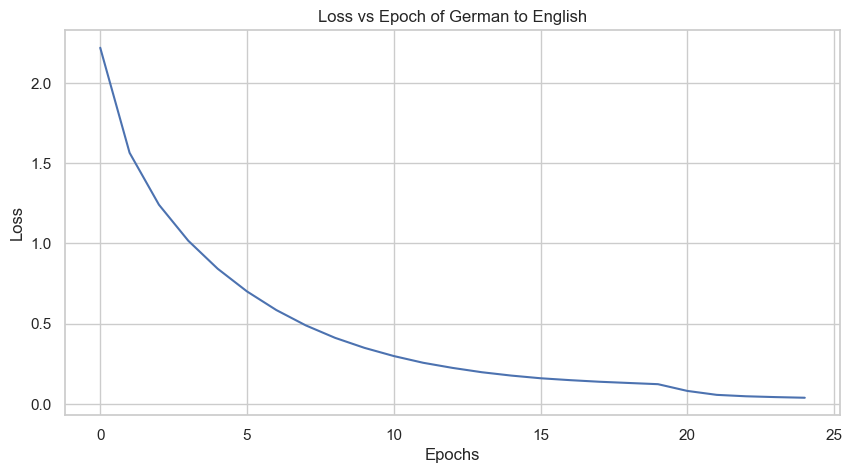

In [273]:
pltLosses(losses, saveImg=True, lang = languages[input_lang])

In [278]:
compute_metrics(encoder, decoder, input_lang)

45.3729505384646

In [275]:
evaluateFirstN(encoder, decoder, input_lang)

From: der marshmallow muss oben drauf sein
To: the marshmallow has to be on top
Prediction: the other got on to the top must be there must be some place

From: und obwohl es wirklich einfach scheint ist es tatsächlich richtig schwer weil es leute drängt sehr schnell zusammenzuarbeiten
To: and though it seems really simple it s actually pretty hard because it forces people to collaborate very quickly
Prediction: and although it s really easy it s real really hard to work

From: es war ein riesiger erfolg
To: and it was a huge success
Prediction: it was a huge success

From: und das ist ziemlich erstaunlich
To: and it s pretty amazing
Prediction: amazing pretty amazing

From: was sie vielleicht fragen werden ist wie kommt das warum was ist mit denen
To: so the question you want to ask is how come why what is it about them
Prediction: what you might ask is how come why is what is this why with what

From: es gibt aber noch einen weiteren grund
To: but there s another reason as well
Predic

In [276]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: sie können diese leute als mitarbeiter anwerben sie können deren arbeit koordinieren und sie bekommen ergebnisse
To: you can hire those people as employees you can coordinate their work and you can get some output
Prediction: you can hire those people as employees you can coordinate their work and you can get some output

From: also alle 2 wochen bauen wir über 5 000 neue teile in das fahrzeug ein
To: so every two weeks we will be making about 5 000 new components to fit to the car
Prediction: so every two weeks we will be making about 5 000 new components to fit to the car

From: man sammelt ein leben lang wissen im gedächtnis
To: you accumulate knowledge throughout your life in memories
Prediction: you accumulate knowledge throughout your life in memories memory

From: aber wahrscheinlich wissen sie kaum etwas über james watt
To: but you probably don t know that much about james watt
Prediction: but you probably don t know that much about james watt above

From: beginnen wir mi

In [277]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: es ist keine wissenschaft der erklärungen
To: it s not a science of explanations
Prediction: it s not rocket science that s not science

From: sie sollen mir etwas über meine marke erzählen
To: they need to tell me about my brand
Prediction: he should tell me something about my age

From: hey warum nicht
To: hey why not
Prediction: does hey why not

From: ich versuche nicht mehr recht zu haben ich entscheide mich dafür glücklich zu sein
To: i no longer try to be right i choose to be happy
Prediction: i don t try to have the right i m trying to make myself for sure

From: sie haben ihre bilder mitgebracht ja
To: you brought your pictures right
Prediction: you ve got your pictures visiting yeah yeah yeah yeah yeah

From: ja ich weiß und die leute hinten sagen okay ich habe das nicht richtig gesehen
To: yeah i know and the people in the back go ok i didn t really see that
Prediction: yeah i know and people say well i don t really have seen this right

From: im jahr 2030 werden drei 

German using bidirectional Encoder

In [353]:
input_lang = languages.index('German')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size, bi_dir=True).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words, bi_dir=True).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.233684025117929
Epoch: [2 / 20] Loss: 1.5980163291718144
Epoch: [3 / 20] Loss: 1.2938420947112896
Epoch: [4 / 20] Loss: 1.0854374303709478
Epoch: [5 / 20] Loss: 0.9249177899373915
Epoch: [6 / 20] Loss: 0.7928750928598383
Epoch: [7 / 20] Loss: 0.6804746016238551
Epoch: [8 / 20] Loss: 0.5862291524319653
Epoch: [9 / 20] Loss: 0.5036993180164261
Epoch: [10 / 20] Loss: 0.4333555571893722
Epoch: [11 / 20] Loss: 0.37604464978614927
Epoch: [12 / 20] Loss: 0.3260829924183714
Epoch: [13 / 20] Loss: 0.28600592697876487
Epoch: [14 / 20] Loss: 0.25218758234914745
Epoch: [15 / 20] Loss: 0.22711757900567933
Epoch: [16 / 20] Loss: 0.20441339815430778
Epoch: [17 / 20] Loss: 0.18727693669118187
Epoch: [18 / 20] Loss: 0.17175860040794377
Epoch: [19 / 20] Loss: 0.16048717351355854
Epoch: [20 / 20] Loss: 0.15165062485205785


In [354]:
losses += train(train_dataloader, encoder, decoder, 5, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.10487303403279537
Epoch: [2 / 5] Loss: 0.07781626960129734
Epoch: [3 / 5] Loss: 0.06641708941486309
Epoch: [4 / 5] Loss: 0.059635674174395116
Epoch: [5 / 5] Loss: 0.054754828211641675


In [361]:
compute_metrics(encoder, decoder, input_lang)

46.192116681515444

In [357]:
evaluateFirstN(encoder, decoder, input_lang)

From: der marshmallow muss oben drauf sein
To: the marshmallow has to be on top
Prediction: the need has to be on top

From: und obwohl es wirklich einfach scheint ist es tatsächlich richtig schwer weil es leute drängt sehr schnell zusammenzuarbeiten
To: and though it seems really simple it s actually pretty hard because it forces people to collaborate very quickly
Prediction: and although it really is easy really is really really because it s actually pretty a lot of time

From: es war ein riesiger erfolg
To: and it was a huge success
Prediction: it was a huge achievement

From: und das ist ziemlich erstaunlich
To: and it s pretty amazing
Prediction: and that s pretty amazing

From: was sie vielleicht fragen werden ist wie kommt das warum was ist mit denen
To: so the question you want to ask is how come why what is it about them
Prediction: what you might be asking is why does what s do about

From: es gibt aber noch einen weiteren grund
To: but there s another reason as well
Predicti

In [358]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: meine familie war nicht arm und ich selbst musste nie hunger leiden
To: my family was not poor and myself i had never experienced hunger
Prediction: my family was not poor my daughter and i never had never been able to never knew poverty

From: ich meine was werde ich heute finden
To: i mean what am i going to find today
Prediction: and i mean what am i going to find today

From: heute spreche ich zu ihnen über energie und klima
To: i m going to talk today about energy and climate
Prediction: today i want to talk to you about energy and today

From: weiß überhaupt noch jemand was das ist
To: does anyone even know what those things are
Prediction: can anyone even know what it is

From: meine freundin musste mich begleiten
To: my friend got to come with me
Prediction: my friend had to me my way into me

From: es ist als wenn man einen stein in einen teich wirft
To: it s like throwing a stone in a pond of water
Prediction: it s like when you re a looking in a pond

From: all das ist

In [359]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: frau sie bestanden darauf ich würde lügen
To: woman they insisted that i was lying
Prediction: woman you know that i insisted to

From: ich danke ihnen allen vielmals
To: thank you all very much
Prediction: thank you so much

From: ja diese länder existieren
To: those things really exist
Prediction: yeah these countries exist

From: ich sagte was ist die geschichte
To: i said what s the story
Prediction: i said what s the story

From: ihr wisst schon all der kram
To: you know all the stuff
Prediction: you know all the stuff

From: wenn wir die 10 cent schaffen geht alles andere von alleine
To: if we can get the 10 cents all the rest of it flows
Prediction: if we can get the 10 cents all the rest of them are running away from all walks

From: danke danke wissen sie was
To: thank you thank you you know what
Prediction: thank you thank you thank you

From: oder sollen wir etwas anderes verwenden
To: or should we use something else
Prediction: or should we use something else

From: u

Italian

In [224]:
input_lang = languages.index('Italian')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.2541820804066917
Epoch: [2 / 20] Loss: 1.5360412606312965
Epoch: [3 / 20] Loss: 1.2170064522153385
Epoch: [4 / 20] Loss: 1.0051499008921245
Epoch: [5 / 20] Loss: 0.8437907690914058
Epoch: [6 / 20] Loss: 0.7151845351120195
Epoch: [7 / 20] Loss: 0.6120232511635076
Epoch: [8 / 20] Loss: 0.5275929822931887
Epoch: [9 / 20] Loss: 0.4586399873329991
Epoch: [10 / 20] Loss: 0.40280158058194204
Epoch: [11 / 20] Loss: 0.35595321053526224
Epoch: [12 / 20] Loss: 0.31817572848133024
Epoch: [13 / 20] Loss: 0.2878317062499208
Epoch: [14 / 20] Loss: 0.26137414954673976
Epoch: [15 / 20] Loss: 0.24107542473016544
Epoch: [16 / 20] Loss: 0.22370975215965833
Epoch: [17 / 20] Loss: 0.20941218454555716
Epoch: [18 / 20] Loss: 0.19926933394735094
Epoch: [19 / 20] Loss: 0.18984886139018967
Epoch: [20 / 20] Loss: 0.1813780958353523


In [230]:
losses += train(train_dataloader, encoder, decoder, 5, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.1260293799851999
Epoch: [2 / 5] Loss: 0.0948663096026436
Epoch: [3 / 5] Loss: 0.08194736084757948
Epoch: [4 / 5] Loss: 0.07346456992633581
Epoch: [5 / 5] Loss: 0.06728980324243955


In [233]:
compute_metrics(encoder, decoder, input_lang)

44.76856373194839

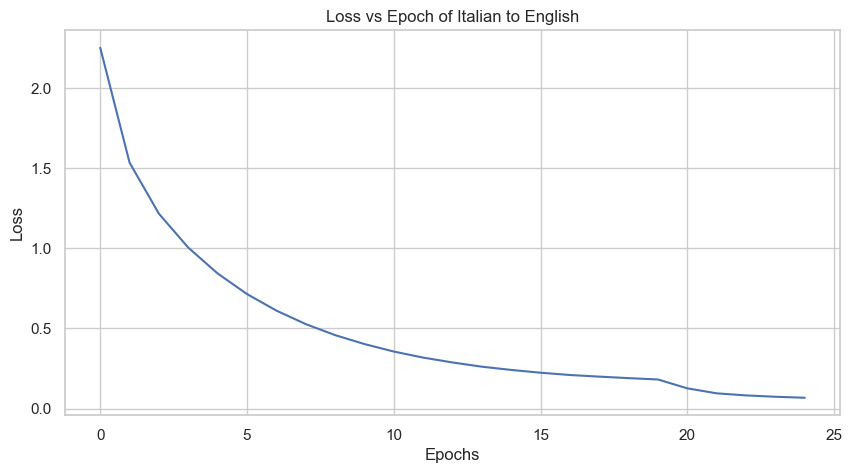

In [234]:
pltLosses(losses, saveImg=True, lang = languages[input_lang])

In [235]:
evaluateFirstN(encoder, decoder, input_lang)

From: e l idea è molto semplice
To: and the idea s pretty simple
Prediction: it s pretty simple

From: il marshmallow deve essere piazzato in cima alla torre
To: the marshmallow has to be on top
Prediction: the operating needs must be in the room to the next

From: e anche se sembra molto semplice di fatto è piuttosto difficile perché costringe le persone a collaborare molto rapidamente
To: and though it seems really simple it s actually pretty hard because it forces people to collaborate very quickly
Prediction: and even though that sounds very simple in fact it s pretty hard because to people a lot of

From: ed è stato un enorme successo
To: and it was a huge success
Prediction: success

From: ed è incredibile
To: and it s pretty amazing
Prediction: incredible incredible

From: e la vostra domanda sarà come è possibile perché che cos hanno di particolare
To: so the question you want to ask is how come why what is it about them
Prediction: and your question will be how is it possible 

In [236]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: e voglio solo dire che le cose non andranno assolutamente così
To: and i just want to say that that is absolutely not going to be the case
Prediction: is this just to say that the absolutely not absolutely the case that absolutely not the case

From: ogni volta che ci si va devi dire di nuovo chi sei
To: each time you go into there you have to tell it again who you are
Prediction: you have to go there you have to tell it again who you are

From: la risposta è 26 per cento
To: answer is 26 percent
Prediction: yes is 26 percent

From: avevo invece tredici mesi quando hanno rimosso l occhio sinistro
To: i was 13 months when they removed my left eye
Prediction: i was 13 months when they removed my left eye

From: ma ha vinto l ipod questo era quello che volevano
To: but the ipod won this is the one they wanted
Prediction: ipod won t that this was that they wanted

From: non va bene non va proprio bene
To: so it s not good it s not really good
Prediction: it s not okay it s not really

In [237]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: e quindi sono stato affetto dal morbo dell esplorazione delle profondità dell oceano
To: and so i really got bitten by the bug of deep ocean exploration
Prediction: and so i was up by the five of the science of the ocean s ocean

From: per darvi un idea della correlazione la correlazione è circa 0 5
To: just to give you a sense of the correlation the correlation is about 5
Prediction: to give you an idea of the correlation s top about five percent

From: ed è una cosa positiva che questo numero aumenti
To: and it s a great thing for this number to go up
Prediction: now this is good and that this number of the number coming up

From: ho letto uno studio un anno fa che mi ha spalancato la mente
To: i read a study a year or so ago that really blew my mind wide open
Prediction: i ve read a study a year ago that was the mind

From: gli ho chiesto come era diventato un tale esperto di pesci
To: i asked him how he became such an expert on fish
Prediction: so i was like how did he a surg

Italian using Bidrectional Encoder

In [342]:
input_lang = languages.index('Italian')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size, bi_dir=True).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words, bi_dir=True).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, print_every=1, plot_every=1, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.2653219581199293
Epoch: [2 / 20] Loss: 1.5748336108449583
Epoch: [3 / 20] Loss: 1.274245259802349
Epoch: [4 / 20] Loss: 1.0771110809698115
Epoch: [5 / 20] Loss: 0.9266295148850838
Epoch: [6 / 20] Loss: 0.8045598455261685
Epoch: [7 / 20] Loss: 0.7014616020828791
Epoch: [8 / 20] Loss: 0.6156338131938722
Epoch: [9 / 20] Loss: 0.5423389256021632
Epoch: [10 / 20] Loss: 0.4804545571375011
Epoch: [11 / 20] Loss: 0.42809174013737455
Epoch: [12 / 20] Loss: 0.3845151897349596
Epoch: [13 / 20] Loss: 0.3471559699053381
Epoch: [14 / 20] Loss: 0.3165383606494592
Epoch: [15 / 20] Loss: 0.29079279896852356
Epoch: [16 / 20] Loss: 0.268038673082903
Epoch: [17 / 20] Loss: 0.24912636097635396
Epoch: [18 / 20] Loss: 0.23566341197188762
Epoch: [19 / 20] Loss: 0.2221562155237698
Epoch: [20 / 20] Loss: 0.21152525198531413


In [343]:
losses += train(train_dataloader, encoder, decoder, 5, print_every=1, plot_every=1, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.151291665575245
Epoch: [2 / 5] Loss: 0.1197044208759308
Epoch: [3 / 5] Loss: 0.10522351069016275
Epoch: [4 / 5] Loss: 0.09550411291512834
Epoch: [5 / 5] Loss: 0.08861365136956012


In [349]:
compute_metrics(encoder, decoder, input_lang)

45.53338043504614

In [350]:
evaluateFirstN(encoder, decoder, input_lang)

From: e l idea è molto semplice
To: and the idea s pretty simple
Prediction: and the idea is very simple

From: il marshmallow deve essere piazzato in cima alla torre
To: the marshmallow has to be on top
Prediction: the marshmallow has to be reached to the top

From: e anche se sembra molto semplice di fatto è piuttosto difficile perché costringe le persone a collaborare molto rapidamente
To: and though it seems really simple it s actually pretty hard because it forces people to collaborate very quickly
Prediction: and even though it s very simple it s quite hard because people mean far in very large cars

From: ed è stato un enorme successo
To: and it was a huge success
Prediction: and it has been huge success

From: ed è incredibile
To: and it s pretty amazing
Prediction: and it s amazing

From: e la vostra domanda sarà come è possibile perché che cos hanno di particolare
To: so the question you want to ask is how come why what is it about them
Prediction: and your questions is what 

In [351]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: e se è così hai un gran lavoro
To: and if you would you ve got a great job
Prediction: and what if you have a big job

From: e dopo
To: in the second three years
Prediction: in a dozen and after

From: e in particolare quelli del settore commerciale per la precisione innovazione creatività e cambiamento
To: this is mostly to be honest with you from the business sector innovation creativity and change
Prediction: this is mostly to do the commercial business for the very social innovation for creativity innovation

From: grazie
To: thank you
Prediction: thank you

From: prima iniziando ho detto che stiamo perdendo la capacità di ascoltare
To: i said at the beginning we re losing our listening
Prediction: i said at first christmas i said is that listening to listen

From: per anni ho detto alle persone che lo stress fa stare male
To: for years i ve been telling people stress makes you sick
Prediction: for years i ve been telling people stress in your life

From: funziona ogni volta


In [352]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: e se possiamo farlo con dati grezzi perché non farlo anche con i contenuti
To: and if we can do this for raw data why not do it for content as well
Prediction: and what if we can do this data but we re not taking it

From: e il motivo è che gli studenti di economia sono formati per trovare il singolo miglior progetto
To: and the reason is that business students are trained to find the single right plan right
Prediction: and the reason for that matter students are used to to find the single best friend

From: sono ottimista francesi e giapponesi hanno fatto del lavoro in questo campo
To: so i m optimistic you know the french and japanese have done some work
Prediction: they re just babies and they ve done for me working in this field

From: alcuni di voi potrebbero pensare é un bel po di tempo passato a giocare
To: some of you might be thinking that s a lot of time to spend playing games
Prediction: some of you might think through half a few days time some time to play

From: ci s

Romanian

In [238]:
input_lang = languages.index('Romanian')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, print_every=1, plot_every=1, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.276208705679207
Epoch: [2 / 20] Loss: 1.605171151152621
Epoch: [3 / 20] Loss: 1.2709339798282635
Epoch: [4 / 20] Loss: 1.0352388335807867
Epoch: [5 / 20] Loss: 0.8544488218465996
Epoch: [6 / 20] Loss: 0.7113533856341994
Epoch: [7 / 20] Loss: 0.5982006148271831
Epoch: [8 / 20] Loss: 0.5067209955148586
Epoch: [9 / 20] Loss: 0.43235783152731716
Epoch: [10 / 20] Loss: 0.3734432094415283
Epoch: [11 / 20] Loss: 0.32554643917002773
Epoch: [12 / 20] Loss: 0.28691435390075015
Epoch: [13 / 20] Loss: 0.2556061361534234
Epoch: [14 / 20] Loss: 0.22954858690083527
Epoch: [15 / 20] Loss: 0.210259598672771
Epoch: [16 / 20] Loss: 0.19408061230035006
Epoch: [17 / 20] Loss: 0.18026230473233565
Epoch: [18 / 20] Loss: 0.16917011548686495
Epoch: [19 / 20] Loss: 0.15986375528850225
Epoch: [20 / 20] Loss: 0.1531671910519558


In [244]:
losses += train(train_dataloader, encoder, decoder, 5, print_every=1, plot_every=1, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.1036655018764689
Epoch: [2 / 5] Loss: 0.07522910491787001
Epoch: [3 / 5] Loss: 0.0641213929376636
Epoch: [4 / 5] Loss: 0.05715097884208119
Epoch: [5 / 5] Loss: 0.05233333270834581


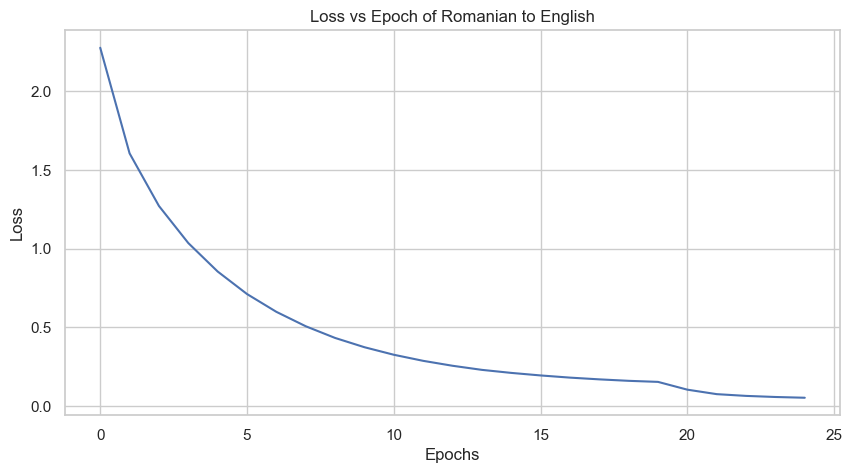

In [245]:
pltLosses(losses, saveImg=True, lang = languages[input_lang])

In [249]:
compute_metrics(encoder, decoder, input_lang)

43.40786357065368

In [250]:
evaluateFirstN(encoder, decoder, input_lang)

From: și ideea este destul de simplă
To: and the idea s pretty simple
Prediction: and the idea is pretty simple

From: și deşi pare destul de simplu e de fapt destul de greu deoarece forțează oamenii să colaboreze foarte rapid
To: and though it seems really simple it s actually pretty hard because it forces people to collaborate very quickly
Prediction: and although the sounds quite gets is pretty hard because your people want to run very quickly

From: și a fost un mare succes
To: and it was a huge success
Prediction: and it was a great success

From: și e destul de uimitor
To: and it s pretty amazing
Prediction: and it s pretty amazing

From: deci ați vrea să întrebați cum de de ce de ce ei
To: so the question you want to ask is how come why what is it about them
Prediction: so you d want to ask how well why why why

From: dar mai este și un alt motiv
To: but there s another reason as well
Prediction: and there is another other reason

From: acesta este că studenţii sunt instruiți să

In [251]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: si incep sa produca din copaci atata cat doresc
To: and they can start producing from the trees as many as they like
Prediction: and they can start producing from the trees as many as they like to me

From: uite ce au fǎcut
To: look what they ve done
Prediction: look what they ve done

From: există un întreg limbaj de programare pentru așa ceva
To: there s a whole programming language and robotics tool
Prediction: there s a whole programming language and robotics tool to realize something

From: publicul arată mi datele
To: audience show me the data
Prediction: turn this show to me

From: acesta este un băiat diferit și aceasta este o fată diferită
To: this is a different kind of boy and a different kind of girl
Prediction: this is a different kind of boy and a this is a different kind of girl a different kind

From: putem construi pe ce au făcut ei
To: we can build on their wisdom
Prediction: we can build on their wisdom what they did

From: sau e vorba doar de niște umbre ciuda

In [252]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: și este un lucru grozav ca acest număr să crească
To: and it s a great thing for this number to go up
Prediction: and it s a great thing so like this this lets grow up

From: limba noastră ne afectează gândirea și felul în care vedem lumea și pe ceilalți oameni
To: our language affects our thinking and how we view the world and how we view other people
Prediction: our language will actually feel the mind and the way we see the world with other people

From: şi au mai fost făcute şi alte eforturi similare
To: and there have been other efforts along those lines
Prediction: and there were also other things we have similar other animals as well

From: nu vrem să încercăm să prezicem viitorul
To: we do not want to try to predict the future
Prediction: we don t want to try and future the future

From: așa că cel care a ajutat la aducerea mea pe lume era un străin pentru părinții mei
To: so the man who delivered me was a complete stranger to my parents
Prediction: so what was the at the

Romanian with bidirectional encoder

In [336]:
input_lang = languages.index('Romanian')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size, bi_dir=True).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words, bi_dir=True).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, print_every=1, plot_every=1, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.283218053355962
Epoch: [2 / 20] Loss: 1.6454156896756547
Epoch: [3 / 20] Loss: 1.3352889664831324
Epoch: [4 / 20] Loss: 1.1158925445137908
Epoch: [5 / 20] Loss: 0.947512782529693
Epoch: [6 / 20] Loss: 0.8109293257504333
Epoch: [7 / 20] Loss: 0.6987619334418822
Epoch: [8 / 20] Loss: 0.6032790964810886
Epoch: [9 / 20] Loss: 0.5241177475457186
Epoch: [10 / 20] Loss: 0.45601577922862574
Epoch: [11 / 20] Loss: 0.40168045414741926
Epoch: [12 / 20] Loss: 0.3545947817150136
Epoch: [13 / 20] Loss: 0.3164892820086995
Epoch: [14 / 20] Loss: 0.2836679367901466
Epoch: [15 / 20] Loss: 0.25704637126974045
Epoch: [16 / 20] Loss: 0.2349061236928522
Epoch: [17 / 20] Loss: 0.2174428298777692
Epoch: [18 / 20] Loss: 0.20186455899353176
Epoch: [19 / 20] Loss: 0.18979202755334326
Epoch: [20 / 20] Loss: 0.1782686116365114


In [337]:
losses += train(train_dataloader, encoder, decoder, 5, print_every=1, plot_every=1, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.12575128972173166
Epoch: [2 / 5] Loss: 0.09645901272565281
Epoch: [3 / 5] Loss: 0.08419184816559934
Epoch: [4 / 5] Loss: 0.07590786668446318
Epoch: [5 / 5] Loss: 0.0697445232782824


In [338]:
compute_metrics(encoder, decoder, input_lang)

45.51261414619624

In [339]:
evaluateFirstN(encoder, decoder, input_lang)

From: și ideea este destul de simplă
To: and the idea s pretty simple
Prediction: and the idea is quite simple

From: și deşi pare destul de simplu e de fapt destul de greu deoarece forțează oamenii să colaboreze foarte rapid
To: and though it seems really simple it s actually pretty hard because it forces people to collaborate very quickly
Prediction: and although it quite pretty easy it s actually pretty hard because people are very quickly for very quickly

From: și a fost un mare succes
To: and it was a huge success
Prediction: and it was a huge success

From: și e destul de uimitor
To: and it s pretty amazing
Prediction: and it s pretty amazing

From: deci ați vrea să întrebați cum de de ce de ce ei
To: so the question you want to ask is how come why what is it about them
Prediction: so you would want to ask what to why do you know why

From: dar mai este și un alt motiv
To: but there s another reason as well
Prediction: but there is another thing but it also is another reason

Fr

In [340]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: cum o fac ei
To: how do they do it
Prediction: how do they do it

From: în primul rând ascultaţi în mod conştient
To: first of all listen consciously
Prediction: first where do they make use of the computer

From: și acelea sunt speciile din mediul uscat
To: and those are the dry land species
Prediction: and those are the species in the environment

From: de fapt când merg în ţările în dezvoltare coca cola pare să fie omniprezentă
To: in fact when i travel to the developing world coke feels ubiquitous
Prediction: actually where i travel to the developing world coke feels ubiquitous

From: cum le pui la dispoziție ca să le fie util
To: how do you put it in their hands so that it is useful
Prediction: how do you put it in the literature so that it s useful to be useful

From: şi umorul e o modalitate bună cred de a aborda aceste probleme serioase
To: and humor is a good way i think to address serious issues
Prediction: and humor humor is a good way i think to address those issues



In [341]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: nu mi place acea întrebare
To: i don t love that question
Prediction: i do not that that question

From: probabil mulţi dintre cei de aici îl stiu deja
To: probably many of you in the room know this trick
Prediction: and many of you probably most of those here say a few of this

From: deci ce realitate vrem să creăm
To: so what reality do we want to call into existence
Prediction: so what do we want to create

From: s au scris multe cărți excelente pe tema aceasta
To: there s a lot of great books that have been written about this
Prediction: many more moved they ve written a lot of teachers on the theme

From: are impactul cel mai mare
To: this is the one with the greatest impact
Prediction: the impact has the impact

From: ci doar încrederea noastră o face reală în corpul nostru şi produce un efect mai puternic
To: it s only your belief that makes it real in your body and makes a stronger effect
Prediction: it s just our creation a bit of makes within our bodies and a huge effec

Arabic

In [257]:
input_lang = languages.index('Arabic')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, print_every=1, plot_every=1, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.306884034621276
Epoch: [2 / 20] Loss: 1.7234810047587037
Epoch: [3 / 20] Loss: 1.3972684761819432
Epoch: [4 / 20] Loss: 1.1425470060270544
Epoch: [5 / 20] Loss: 0.9346702468181298
Epoch: [6 / 20] Loss: 0.7643554626795968
Epoch: [7 / 20] Loss: 0.6267631051250374
Epoch: [8 / 20] Loss: 0.5144614280161568
Epoch: [9 / 20] Loss: 0.42587841757510975
Epoch: [10 / 20] Loss: 0.35586604257583143
Epoch: [11 / 20] Loss: 0.30012875872618655
Epoch: [12 / 20] Loss: 0.2570051189924285
Epoch: [13 / 20] Loss: 0.22202697606870564
Epoch: [14 / 20] Loss: 0.19719726141033359
Epoch: [15 / 20] Loss: 0.17560897145795443
Epoch: [16 / 20] Loss: 0.15977266519622932
Epoch: [17 / 20] Loss: 0.14721286666030778
Epoch: [18 / 20] Loss: 0.13722293124954818
Epoch: [19 / 20] Loss: 0.12870297119660248
Epoch: [20 / 20] Loss: 0.12165755985800553


In [265]:
losses += train(train_dataloader, encoder, decoder, 5, print_every=1, plot_every=1, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.08301577468775027
Epoch: [2 / 5] Loss: 0.05930629861471452
Epoch: [3 / 5] Loss: 0.050312665461052807
Epoch: [4 / 5] Loss: 0.04461997692823291
Epoch: [5 / 5] Loss: 0.04108574728138841


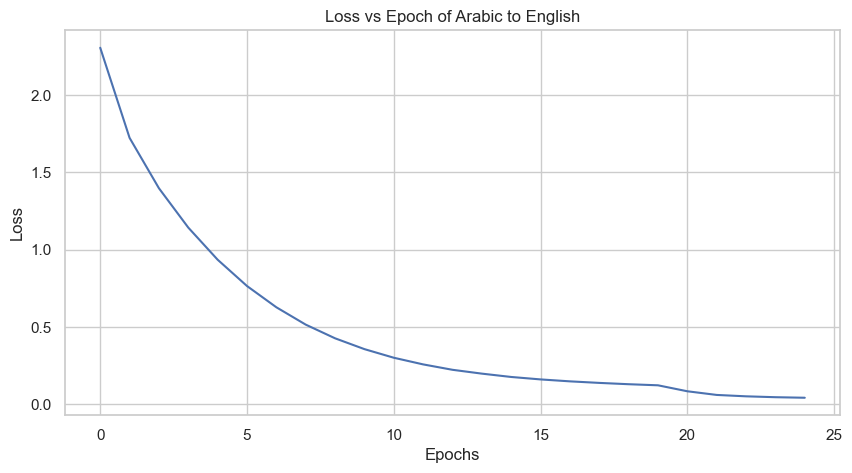

In [266]:
pltLosses(losses, saveImg=True, lang = languages[input_lang])

In [267]:
compute_metrics(encoder, decoder, input_lang)

29.70792202695846

In [268]:
evaluateFirstN(encoder, decoder, input_lang)

From: وقد كان نجاحا باهرا
To: and it was a huge success
Prediction: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

From: وهذا شئ رائع حقا
To: and it s pretty amazing
Prediction: yeah that s really cool

From: لكن هناك سبب آخر أيضا
To: but there s another reason as well
Prediction: too another one too

From: إنها أزمة
To: it s a crisis
Prediction: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

From: تبدو مألوفا أليس كذلك
To: sound familiar right
Prediction: isn t look right

From: وقد حاولت شيئا مثيرا
To: and i tried something interesting
Prediction: SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

From: لذا فقد عرضت جائزة قدرها 10 000 دولار من البرمجيات للفريق الفائز
To: so i offered a 10 000 dollar prize of software to the winning team
Prediction: so my uncle had 10 000 dollars out of a space and ancient chemistry

From: ماذا كانت النتيجة
To: what was the result
Prediction: SOS SOS SOS SOS SOS SOS 

In [269]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: وهكذا انتشر الإعلان حول العالم
To: and this is how the ad ran around the world
Prediction: around the world

From: لكن الجدري كان رابع مرض ق صد القضاء عليه
To: but smallpox was the fourth disease that was intended for eradication
Prediction: animation the disease was seen for eradication

From: ماذا عن التعليم للشباب
To: what about education for young people
Prediction: young men by young education

From: منتشرة تماما في سوق أدوية السرطان الآن
To: jc so these drugs aren t exactly in mainstream cancer treatments right now
Prediction: for almost not just in the stock market right now cancer treatments right now

From: هذا البروتين فقط
To: just this one protein
Prediction: only solve only these protein protein

From: لذا كنت تنوي وضع الإبهام على رأس هذا
To: so you re going to put your thumb on top of this
Prediction: so you re going to put your thumb on top of this

From: شكرا شكرا
To: thank you thank you
Prediction: thank you thank you

From: كنا نذهب إلى كل مكان
To: we were going 

In [270]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: كنت قادرة على انهاء قصة الحب المجنون الخاصة بي عن طريق كسر الصمت
To: i was able to end my own crazy love story by breaking the silence
Prediction: i was producing the story of love and my mother took me through the opposite of silence

From: وقال إنني فخور جدا بك
To: he said i m so proud of you
Prediction: very low people that were said

From: وبالتأكيد فإننا يمكن ان نعثر على مطاعم الوجبات السريعة
To: and sure we could find fast food chains
Prediction: and of course you can take on the other hand of that memory on the other hand

From: وها أنا اليوم
To: and here s me today
Prediction: am i am today

From: سوف نكون على ما يرام
To: we re going to be okay
Prediction: sorry

From: يتحدث الجميع هذه الأيام عن السعادة
To: everybody talks about happiness these days
Prediction: those days these days happiness

From: تلك هي أنا أعزف البيانو الوهمي
To: that is me playing my imaginary piano
Prediction: sorry i m sure you know what i am saying

From: وفي اعتقادي أن هذا ما نراه في انفجار المنح

Training Arabic with BIDIRECTIONAL Model

In [330]:
input_lang = languages.index('Arabic')
train_dataloader = get_dataloader(batch_size, input_lang)
encoder = EncoderRNN(lang_classes[input_lang].n_words, hidden_size, bi_dir=True).to(device)
decoder = AttnDecoderRNN(hidden_size, lang_classes[-1].n_words, bi_dir=True).to(device)
print(f"STARTING TO TRAIN")
losses = train(train_dataloader, encoder, decoder, 20, print_every=1, plot_every=1, learning_rate=3e-4)

STARTING TO TRAIN
Epoch: [1 / 20] Loss: 2.312631453973346
Epoch: [2 / 20] Loss: 1.7507209871725689
Epoch: [3 / 20] Loss: 1.4517154598818462
Epoch: [4 / 20] Loss: 1.2214514615825738
Epoch: [5 / 20] Loss: 1.0315069198786677
Epoch: [6 / 20] Loss: 0.8749857827471356
Epoch: [7 / 20] Loss: 0.7397498107057506
Epoch: [8 / 20] Loss: 0.6269697754208373
Epoch: [9 / 20] Loss: 0.5317056690261942
Epoch: [10 / 20] Loss: 0.4525835040886167
Epoch: [11 / 20] Loss: 0.38672388405172325
Epoch: [12 / 20] Loss: 0.33490043364517236
Epoch: [13 / 20] Loss: 0.2916887542037878
Epoch: [14 / 20] Loss: 0.2565666282789063
Epoch: [15 / 20] Loss: 0.22885979022292174
Epoch: [16 / 20] Loss: 0.20629877796914736
Epoch: [17 / 20] Loss: 0.18822506005139436
Epoch: [18 / 20] Loss: 0.17346174827036806
Epoch: [19 / 20] Loss: 0.16049120223088373
Epoch: [20 / 20] Loss: 0.15042830010131372


In [331]:
losses += train(train_dataloader, encoder, decoder, 5, print_every=1, plot_every=1, learning_rate=1e-4)

Epoch: [1 / 5] Loss: 0.10601006456254308
Epoch: [2 / 5] Loss: 0.08061161673704863
Epoch: [3 / 5] Loss: 0.06965611843486964
Epoch: [4 / 5] Loss: 0.06313293845256268
Epoch: [5 / 5] Loss: 0.05788539712812198


In [335]:
compute_metrics(encoder, decoder, input_lang)

36.0471056270025

In [332]:
evaluateFirstN(encoder, decoder, input_lang)

From: وقد كان نجاحا باهرا
To: and it was a huge success
Prediction: and it has huge

From: وهذا شئ رائع حقا
To: and it s pretty amazing
Prediction: that s really cool

From: لكن هناك سبب آخر أيضا
To: but there s another reason as well
Prediction: but still matters another reason

From: إنها أزمة
To: it s a crisis
Prediction: it s a crisis crisis

From: تبدو مألوفا أليس كذلك
To: sound familiar right
Prediction: it looks like right

From: وقد حاولت شيئا مثيرا
To: and i tried something interesting
Prediction: and you did something interesting

From: لذا فقد عرضت جائزة قدرها 10 000 دولار من البرمجيات للفريق الفائز
To: so i offered a 10 000 dollar prize of software to the winning team
Prediction: so he s hearing the simulation but they would fit 10 000 dollars a cell software

From: ماذا كانت النتيجة
To: what was the result
Prediction: how what was the result

From: ها هو ما حدث لم ينجح حتى فريق واحد في إيقاف الهيكل
To: here s what happened not one team had a standing structure
Prediction: 

In [333]:
evaluateRandomly(encoder, decoder, input_lang, set='train')

From: وهم ليسوا س عداء بهذا
To: and they re not happy with this
Prediction: and they re not actually cool with this

From: نعم يمكن ذلك و سوف أريكم خلال ثواني كيف يمكن عمل ذلك
To: yes you can and i ll show you in a second how to do that
Prediction: yes yes you can and i ll show you how to do that

From: وذات صباح كنت راكبا في قطار الأنفاق
To: and one morning i was riding the subway
Prediction: and i was still fighting in the classroom of room

From: وقد جعلتني أرغب باكتشاف المزيد
To: and it made me want to explore more
Prediction: and it made the business revolution

From: بعضكم يتذكر هذا إنني متأكد
To: some of you remember this i m sure
Prediction: some of you may remember this

From: ربما ينبغي علينا أن نجعل الناس يدخرون أكثر عندما يكسبون مالا أكثر
To: maybe we should make people save more when they make more money
Prediction: maybe we should make people save more less when we make more money

From: وقد مثل الأمر إلهاما لي
To: and this was an inspiration to me
Prediction: and this wa

In [334]:
evaluateRandomly(encoder, decoder, input_lang, set='test')

From: هذه البيانات لم تكن متوفرة سابقا
To: this data was not available before
Prediction: this data wasn t rocket science

From: سأخبركم كيف استطعنا ان نكتشف هذه الدودة الالكترونية
To: i want to tell you how we found that out
Prediction: how could you feeling how this could be built

From: أنا أعمل في صناعة تكنولوجيا الطاقة الشمسية
To: now i work in the solar technology industry
Prediction: i work at a technology overall energy

From: ولكن القصد هو
To: but the point is
Prediction: but the whole thing but it is

From: صدرت عن جامعة واشنطن في سياتل
To: it came out of the university of washington in seattle
Prediction: this pass from her washington d c

From: أنه شئ شخصي
To: it s personal
Prediction: something dangerous is something

From: تحول العالم إلى ثقب أسود كبير
To: the world turned into a big black hole
Prediction: the world in large numbers are so high

From: ولكن هناك شيء آخر
To: but there s another thing
Prediction: but something else has there

From: كيف نخطو الخطوة التالية
To